In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mr-dataset/marathi_preprocessed_2.csv
/kaggle/input/hindi-dataset/hindi_preprocessed_2.csv


In [21]:
# import torch
# from transformers import AutoTokenizer, AutoModel
# import numpy as np
# from torch.utils import data
# from sklearn.model_selection import train_test_split
# import pandas as pd
from tqdm import tqdm

In [22]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

In [23]:
import torch

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))


else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [24]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

In [25]:
class IndicBertClassfier(torch.nn.Module):
    def __init__(self,bert_model,bert_config,num_class):
        super(IndicBertClassfier,self).__init__()
        
        self.bert_model=bert_model
        self.dropout=torch.nn.Dropout(0.1)
        self.fc1=torch.nn.Linear(bert_config["hidden_size"],bert_config["hidden_size"])
        self.fc2=torch.nn.Linear(bert_config["hidden_size"],num_class)
    def forward(self,token_ids):
        bert_out=self.bert_model(token_ids)[1] #Sentence vector [batch_size,hidden_size]
        bert_out=self.dropout(bert_out)
        bert_out=self.fc1(bert_out) 
        bert_out=self.dropout(bert_out)
        bert_out=self.fc2(bert_out) #[batch_size,num_class]
        return bert_out

In [26]:
config = {
  "model_type": "albert",
  "attention_probs_dropout_prob": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "embedding_size": 128,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_hidden_groups": 1,
  "net_structure_type": 0,
  "gap_size": 0,
  "num_memory_blocks": 0,
  "inner_group_num": 1,
  "down_scale_factor": 1,
  "type_vocab_size": 2,
  "vocab_size": 200000
}

In [27]:
import pandas as pd
test_data = pd.read_csv("/kaggle/input/mr-dataset/marathi_preprocessed_2.csv")
test_data.rename(columns = {'tweet':'sentence', 'label':'label'}, inplace = True)

print('Number of training sentences: {:,}\n'.format(test_data.shape[0]))
test_data.dropna()
test_data.sample(10)

Number of training sentences: 3,585



,sentence,label
3325,आपल्या कार्याद्वारे समाजसेवेचा वसा असाचं चालू ...,1
116,काटे च्या चांगलेच काटे रुतलेली दिसतात अरे बावळ...,1
3064,मी एक बोलू कात्याला असं बोलायचंय कि आग लागायल...,1
2729,खूप चांगला निर्णय घेतला साहेबधन्यवाद।,1
2575,भिलवडी गावातील पुरग्रस्तांच्या व्यथा ऐकून घेतल...,1
83,चा स्वस्त वेरिएंट कंपनीच्या साइट वर झाला लिस्ट...,1
1969,तुझी पुच्ची लय मोठी झाली असील ना आता रोज किती ...,0
1668,तुज्येइ रांड आहे रे कोना खाली लगेच जाती,0
1917,अरे मुर्खा आता संघात पूर्ण पँट असते पण तुझ्या ...,0
1480,किती मोठी गम्मत आहे ना जेव्हा ह्यांनी मुलींना ...,0


In [28]:
def get_test_data(train_data,max_length=128):
    data=[]
    labels = []
    
    comments = list(train_data["sentence"])
    tags = list(train_data["label"])
    for i in range(len(comments)):
        #row = tokenize(train_data["commentText"][i])
        row = comments[i]
        ids=tokenizer.encode(row.strip(),max_length=max_length,padding='max_length',truncation=True)
        data.append(ids)
        labels.append(tags[i])    
    
    return (data,labels)

In [29]:
from torch.utils import data
class DataGen(data.Dataset):
    def __init__(self,data,label):
        self.data=data
        self.label=label
    def __len__(self):
        return len(self.data)
            
    def __getitem__(self,index):
        return np.array(self.data[index]),np.array(self.label[index])

In [30]:
test_x,test_labels = get_test_data(test_data)

In [31]:
IndicBertClassfier = IndicBertClassfier(model,config,2)

In [32]:
device=torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
IndicBertClassfier = IndicBertClassfier.to(device)

In [33]:
model_eval = IndicBertClassfier

In [34]:
test_datase=DataGen(test_x,test_labels)
test_dataload=data.DataLoader(test_datase,batch_size=32)

In [36]:
preds = []

for steps,(token_ids,label) in tqdm(enumerate(test_dataload)):
    
    #print(steps)
    with torch.no_grad():
        
        token_ids = token_ids.to(device)
        out=model_eval(token_ids)
        res = list(out.argmax(1))
        for r in res:
            preds.append(r.tolist())

113it [00:28,  3.98it/s]


In [37]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.34      0.73      0.46      1178
           1       0.69      0.30      0.42      2407

    accuracy                           0.44      3585
   macro avg       0.52      0.52      0.44      3585
weighted avg       0.58      0.44      0.43      3585



In [38]:
from sklearn.metrics import f1_score

# Compute F1 score
f1 = f1_score(test_labels, preds, average='macro')

print("F1 Score:", f1)

F1 Score: 0.4404540074670497


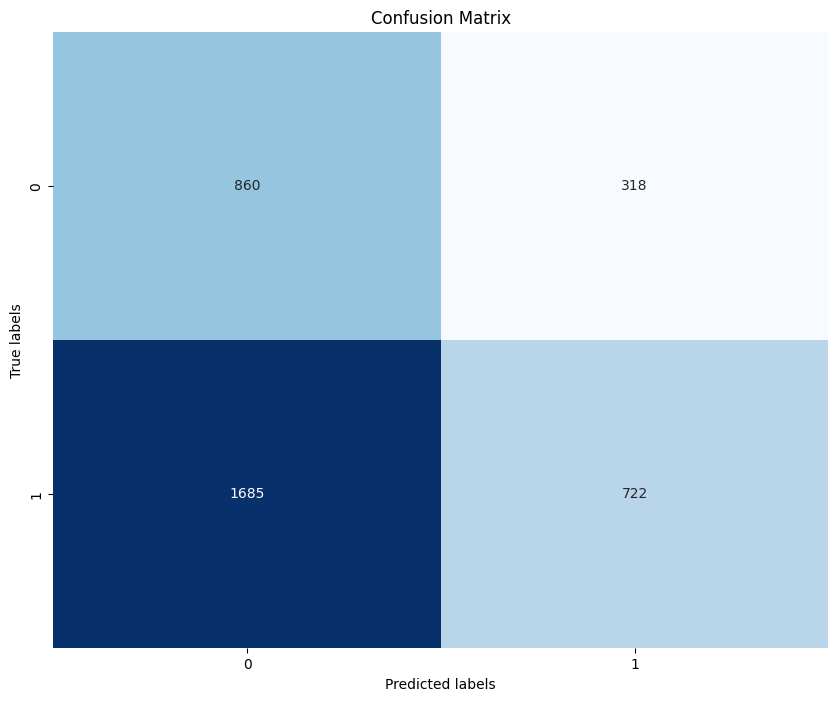

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `test_labels` and `preds` are your true labels and predicted labels, respectively

# Compute confusion matrix
cm = confusion_matrix(test_labels, preds)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
